<a href="https://colab.research.google.com/github/ikszn/TransportProject/blob/main/GRUv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. Importing Necessary Libraries**

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import keras_tuner as kt

# **1. Load and Preprocess the Data**

In [29]:
df = pd.read_excel("/content/drive/MyDrive/AML Dataset/df_with_demand.xlsx")
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')

# Add time-based features
df['hour'] = df['datetime'].dt.hour / 23.0
df['day_of_week'] = df['datetime'].dt.dayofweek / 6.0

# ✅ Add previous day's price lags
df['price_t-24'] = df['day_ahead_price'].shift(24)
df['price_t-48'] = df['day_ahead_price'].shift(48)
df['price_t-72'] = df['day_ahead_price'].shift(72)

# Drop NaNs caused by lagging
df = df.dropna().reset_index(drop=True)

# ✅ Update input features to include lagged prices
input_features = [
    'residual_demand', 'hourly_demand', 'coal', 'natural_gas', 'lignite',
    'solar', 'onshore_wind', 'offshore_wind', 'net_flows', 'biomass',
    'hour', 'day_of_week',
    'price_t-24', 'price_t-48', 'price_t-72'  # ✅ newly added features
]

target_feature = 'day_ahead_price'

In [30]:
# Extract data
X_data = df[input_features].values.astype('float32')
y_data = df[[target_feature]].values.astype('float32')

# **2. Scale features**



In [31]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_data)
y_scaled = scaler_y.fit_transform(y_data)


# **3. Create Sequences before split**

In [32]:
look_back = 48

def create_sequences(X, y, look_back):
    X_seq, y_seq = [], []
    for i in range(len(X) - look_back):
        X_seq.append(X[i:i+look_back])
        y_seq.append(y[i+look_back])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, look_back)


# **4. Split Sequences Chronologically**

In [33]:
total_samples = X_seq.shape[0]
train_end = int(total_samples * 0.6)
val_end = int(total_samples * 0.8)

X_train_seq, y_train_seq = X_seq[:train_end], y_seq[:train_end]
X_val_seq, y_val_seq = X_seq[train_end:val_end], y_seq[train_end:val_end]
X_test_seq, y_test_seq = X_seq[val_end:], y_seq[val_end:]

# **5. Define Model Builder for Tuner**


In [34]:
# **5. Model builder for Keras Tuner**
def build_model(hp):
    model = Sequential()
    model.add(GRU(
        units=hp.Int('units1', 100, 300, step=50),
        return_sequences=True,
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    ))
    model.add(Dropout(hp.Float('dropout1', 0.1, 0.3, step=0.1)))
    model.add(GRU(
        units=hp.Int('units2', 100, 300, step=50),
        return_sequences=False
    ))
    model.add(Dropout(hp.Float('dropout2', 0.1, 0.3, step=0.1)))
    model.add(Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')
        ),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

# **6. Hyperparameter tuning**

In [35]:
rtuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=10,
    seed=42,
    overwrite=True,
    directory="/content/drive/MyDrive/AML Dataset/tuner_output",
    project_name='gru_tuned_fixed'
)

EarlyStopping(monitor='val_loss', patience=15, min_delta=1e-5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

rtuner.search(
    X_train_seq, y_train_seq,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stop, reduce_lr]
)


Trial 10 Complete [00h 00m 26s]
val_loss: 0.003280055709183216

Best val_loss So Far: 0.0021890720818191767
Total elapsed time: 00h 04m 16s


# **7. Train the Best Model**

In [36]:
best_model = rtuner.get_best_models(1)[0]
best_hyperparameters = rtuner.get_best_hyperparameters(1)[0].values
print("Best hyperparameters:", best_hyperparameters)

history = best_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=40,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)

Best hyperparameters: {'units1': 100, 'dropout1': 0.1, 'units2': 250, 'dropout2': 0.1, 'learning_rate': 0.0038287047044982298}
Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0247 - mae: 0.0959 - val_loss: 0.0026 - val_mae: 0.0271 - learning_rate: 0.0038
Epoch 2/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0016 - mae: 0.0313 - val_loss: 0.0026 - val_mae: 0.0291 - learning_rate: 0.0038
Epoch 3/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - mae: 0.0257 - val_loss: 0.0024 - val_mae: 0.0299 - learning_rate: 0.0038
Epoch 4/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - mae: 0.0255 - val_loss: 0.0023 - val_mae: 0.0255 - learning_rate: 0.0038
Epoch 5/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - mae: 0.0263 - val_loss: 0.0027 - val_mae: 0.0331 - learning_rate: 0.0038
Epoch 6/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0010 - mae: 0.0246 - val_loss: 0.0023 - val_mae: 0.0256 - learning_rate: 0.0038
Epoch 7/40
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.1205e-04 - mae: 0.0232 - val_loss: 0.0024 - val_mae: 0.0257 - learning_rate: 0.0038
Epoch 8/40
96/96 ━━━

# **8. Make Predictions with the Best Model**


In [37]:
predictions = best_model.predict(X_test_seq)
predicted_prices = scaler_y.inverse_transform(predictions)
actual_prices = scaler_y.inverse_transform(y_test_seq)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


# **9. Evaluate the Model's Performance**

In [38]:
mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
r_squared = r2_score(actual_prices, predicted_prices)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r_squared}")

MAE: 4.791974067687988
MSE: 47.92348861694336
RMSE: 6.922679294676546
R²: 0.5452790260314941


# **10. Plot Results**


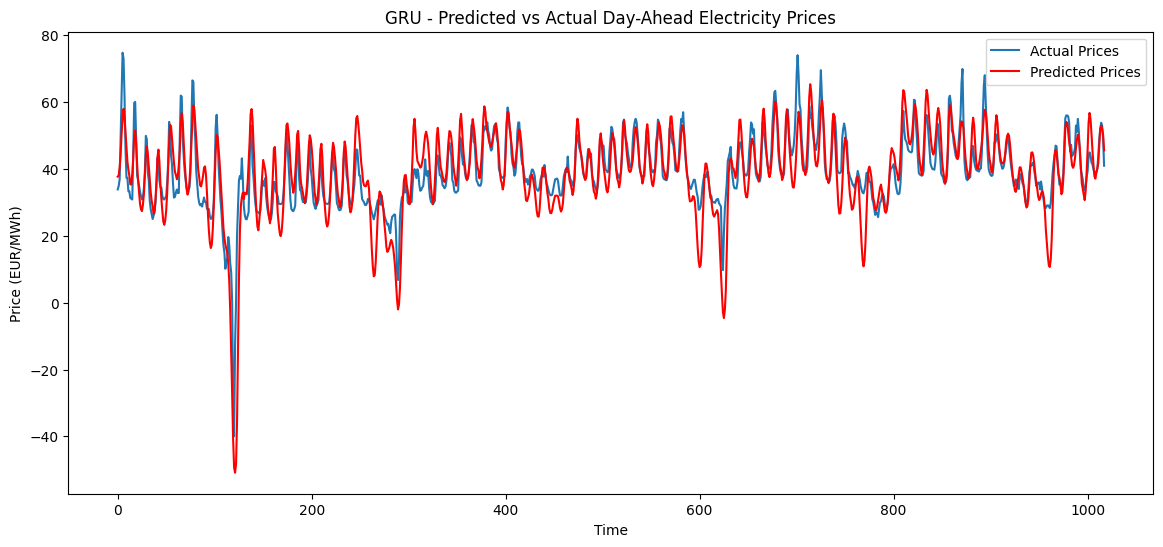

In [39]:
plt.figure(figsize=(14,6))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(predicted_prices, label='Predicted Prices', color='red')
plt.title('GRU - Predicted vs Actual Day-Ahead Electricity Prices')
plt.xlabel('Time')
plt.ylabel('Price (EUR/MWh)')
plt.legend()
plt.show()

# **11. Training & Validation loss**


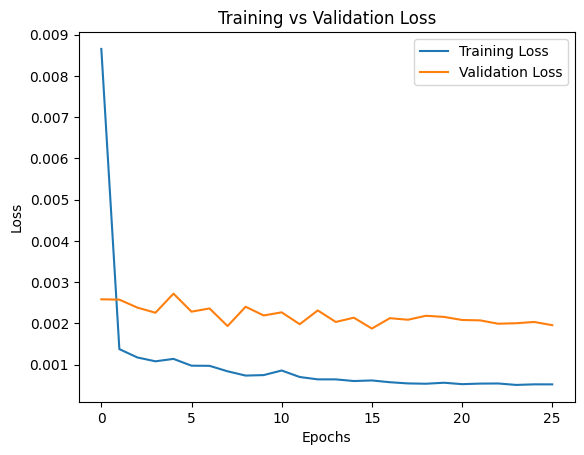

In [40]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

# **12. MAE Trend**


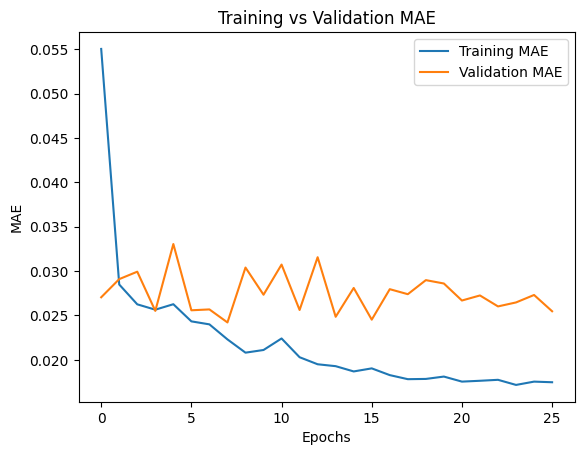

In [41]:
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Training vs Validation MAE')
plt.show()

In [28]:
df[input_features + [target_feature]].corr()[target_feature].sort_values()

,day_ahead_price
onshore_wind,-0.265582
offshore_wind,-0.179729
day_of_week,-0.113479
solar,-0.090361
hour,0.088107
hourly_demand,0.118957
net_flows,0.183065
natural_gas,0.188885
biomass,0.269910
residual_demand,0.364645
